# 🗺️ VCT 2024: Map & Veto Tactical Analysis
Explore which maps are favored by specific teams, how the "Veto" process influences match outcomes, and the tactical balance (Attack vs. Defense) across the VCT 2024 season.

**Key Objectives:**
1. **Veto Analysis**: Understanding Pick/Ban patterns in Bo3 and Bo5 series.
2. **Team DNA**: Identifying "Comfort Maps" and "Permabans" for top-tier teams.
3. **Map Dynamics**: Analyzing round durations and side-bias (Atk/Def win %).
4. **Decider Impact**: How performance varies when matches go to the final map.

## 1. Setup & Data Loading
We start by importing the necessary libraries for data manipulation and visualization.

In [742]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import math

In [743]:
matches_maps_df = pd.read_csv("VCT_2024_seoul_dataset/detailed_matches_maps.csv")
matches_overview_df = pd.read_csv("VCT_2024_seoul_dataset/detailed_matches_overview.csv")

In [744]:
matches_maps_df.head()

,match_id,map_name,map_order,score,winner,duration,picked_by
0,378662,Haven,1,13 - 8,Gen.G,1:02:40,Sentinels
1,378662,Ascent,2,13 - 7,Gen.G,46:45,Gen.G
2,378663,Abyss,1,12 - 14,Team Heretics,1:10:12,FunPlus Phoenix
3,378663,Bind,2,13 - 9,FunPlus Phoenix,53:01,Team Heretics
4,378663,Lotus,3,13 - 15,Team Heretics,1:07:12,Decider


In [745]:
matches_overview_df.head()

,match_id,match_title,event,date,format,teams,score,maps_played,patch,pick_ban_info
0,378662,Gen.G vs Sentinels,Valorant Champions 2024,2024-08-01 04:00:00,Bo3,Gen.G vs Sentinels,2 - 0,2,Patch 9.02,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...
1,378663,FunPlus Phoenix vs Team Heretics,Valorant Champions 2024,2024-08-01 06:25:00,Bo3,FunPlus Phoenix vs Team Heretics,1 - 2,3,Patch 9.02,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...
2,378657,DRX vs KRÜ Esports,Valorant Champions 2024,2024-08-02 04:00:00,Bo3,DRX vs KRÜ Esports,2 - 1,3,Patch 9.02,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...
3,378656,FNATIC vs Bilibili Gaming,Valorant Champions 2024,2024-08-02 07:00:00,Bo3,FNATIC vs Bilibili Gaming,2 - 0,2,Patch 9.02,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...
4,378667,LEVIATÁN vs TALON,Valorant Champions 2024,2024-08-03 04:00:00,Bo3,LEVIATÁN vs TALON,2 - 0,2,Patch 9.02,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...


## 2. Data Cleaning & Feature Engineering
The raw VCT data requires significant transformation to be useful for analysis. In this section, we:
* **Drop Redundant Columns**: Droping the `'date', 'patch', 'match_title', 'event'` 
* **Split Scores**: Breaking the `score` string into numerical columns for Team 1 and Team 2.
* **Standardize Names**: Mapping team abbreviations (e.g., `SEN`) to full names (`Sentinels`) for consistency.
* **Parse Vetoes**: Extracting the sequential Pick/Ban logic from the raw text strings.

In [746]:
# drop redundant columns
matches_overview_df = matches_overview_df.drop(columns=['date', 'patch', 'match_title', 'event'])
matches_overview_df.head()

,match_id,format,teams,score,maps_played,pick_ban_info
0,378662,Bo3,Gen.G vs Sentinels,2 - 0,2,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...
1,378663,Bo3,FunPlus Phoenix vs Team Heretics,1 - 2,3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...
2,378657,Bo3,DRX vs KRÜ Esports,2 - 1,3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...
3,378656,Bo3,FNATIC vs Bilibili Gaming,2 - 0,2,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...
4,378667,Bo3,LEVIATÁN vs TALON,2 - 0,2,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...


### Split the `teams` columns with teams names into 2 separate team columns

In [747]:
# split the teams columns into 2 seperated team columns
matches_overview_df[['team1', 'team2']] = matches_overview_df['teams'].str.split(' vs ', expand = True)
matches_overview_df = matches_overview_df.drop(columns=['teams'])
matches_overview_df.head()

,match_id,format,score,maps_played,pick_ban_info,team1,team2
0,378662,Bo3,2 - 0,2,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,Gen.G,Sentinels
1,378663,Bo3,1 - 2,3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,FunPlus Phoenix,Team Heretics
2,378657,Bo3,2 - 1,3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,DRX,KRÜ Esports
3,378656,Bo3,2 - 0,2,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,FNATIC,Bilibili Gaming
4,378667,Bo3,2 - 0,2,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,LEVIATÁN,TALON


### Split the `score` columns with teams names into 2 separate team score columns and picking the winner and looser for each match 

In [748]:
# Split the score into two seperate columns for each teams score
matches_overview_df[['team1_score', 'team2_score']] = matches_overview_df['score'].str.split(' - ', expand = True)
# Convert the scores from string to integers
matches_overview_df['team1_score'] = matches_overview_df['team1_score'].astype(int)
matches_overview_df['team2_score'] = matches_overview_df['team2_score'].astype(int)
matches_overview_df['winner']  = np.where(matches_overview_df['team1_score']>matches_overview_df['team2_score'], matches_overview_df['team1'], matches_overview_df['team2'])
matches_overview_df['looser'] = np.where(matches_overview_df['team1_score'] < matches_overview_df['team2_score'], matches_overview_df['team1'], matches_overview_df['team2'])

matches_overview_df = matches_overview_df.drop(columns = ['score'])
matches_overview_df

,match_id,format,maps_played,pick_ban_info,team1,team2,team1_score,team2_score,winner,looser
0,378662,Bo3,2,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,Gen.G,Sentinels,2,0,Gen.G,Sentinels
1,378663,Bo3,3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix
2,378657,Bo3,3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,DRX,KRÜ Esports,2,1,DRX,KRÜ Esports
3,378656,Bo3,2,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,FNATIC,Bilibili Gaming,2,0,FNATIC,Bilibili Gaming
4,378667,Bo3,2,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,LEVIATÁN,TALON,2,0,LEVIATÁN,TALON
5,378669,Bo3,3,TE ban Icebox; VIT ban Lotus; TE pick Ascent; ...,Team Vitality,Trace Esports,1,2,Trace Esports,Team Vitality
6,378674,Bo3,2,PRX ban Ascent; G2 ban Sunset; PRX pick Icebox...,G2 Esports,Paper Rex,2,0,G2 Esports,Paper Rex
7,378673,Bo3,2,FUT ban Haven; EDG ban Ascent; FUT pick Lotus;...,EDward Gaming,FUT Esports,2,0,EDward Gaming,FUT Esports
8,378664,Bo3,3,TH ban Ascent; GEN ban Sunset; TH pick Abyss; ...,Gen.G,Team Heretics,1,2,Team Heretics,Gen.G
9,378658,Bo3,2,DRX ban Haven; FNC ban Icebox; DRX pick Abyss;...,FNATIC,DRX,0,2,DRX,FNATIC


### Creating a separate dataframe to process the `pick_ban_info` and segregate it into different action columns for the map veto

In [749]:
# create a DataFrame with pick/ban info, match_id and format
pick_info = matches_overview_df[['match_id', 'format','pick_ban_info']].copy()
pick_info = pick_info.set_index('match_id')

# split the pick_ban_info into separate columns
veto_actions = pick_info['pick_ban_info'].str.split(";", expand=True)

# Dynamically name the columns based on the number of splits
veto_cols = [f'action{i+1}' for i in range(veto_actions.shape[1])]

#Assign the new columns to the original DataFrame
pick_info[veto_cols] = veto_actions


#pick_info[['action1', 'action2', 'action3', 'action4', 'action5', 'action6', 'action7']] = pick_info['pick_ban_info'].str.split(";", expand = True)
pick_info

,format,pick_ban_info,action1,action2,action3,action4,action5,action6,action7
match_id,,,,,,,,,
378662,Bo3,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,SEN ban Icebox,GEN ban Sunset,SEN pick Haven,GEN pick Ascent,SEN ban Bind,GEN ban Lotus,Abyss remains
378663,Bo3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,FPX ban Sunset,TH ban Icebox,FPX pick Abyss,TH pick Bind,FPX ban Ascent,TH ban Haven,Lotus remains
378657,Bo3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,KRÜ ban Icebox,DRX ban Lotus,KRÜ pick Haven,DRX pick Abyss,KRÜ ban Ascent,DRX ban Sunset,Bind remains
378656,Bo3,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,BLG ban Haven,FNC ban Sunset,BLG pick Bind,FNC pick Lotus,BLG ban Abyss,FNC ban Icebox,Ascent remains
378667,Bo3,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,TLN ban Icebox,LEV ban Lotus,TLN pick Bind,LEV pick Ascent,TLN ban Haven,LEV ban Abyss,Sunset remains
378669,Bo3,TE ban Icebox; VIT ban Lotus; TE pick Ascent; ...,TE ban Icebox,VIT ban Lotus,TE pick Ascent,VIT pick Sunset,TE ban Abyss,VIT ban Haven,Bind remains
378674,Bo3,PRX ban Ascent; G2 ban Sunset; PRX pick Icebox...,PRX ban Ascent,G2 ban Sunset,PRX pick Icebox,G2 pick Lotus,PRX ban Haven,G2 ban Abyss,Bind remains
378673,Bo3,FUT ban Haven; EDG ban Ascent; FUT pick Lotus;...,FUT ban Haven,EDG ban Ascent,FUT pick Lotus,EDG pick Bind,FUT ban Abyss,EDG ban Icebox,Sunset remains
378664,Bo3,TH ban Ascent; GEN ban Sunset; TH pick Abyss; ...,TH ban Ascent,GEN ban Sunset,TH pick Abyss,GEN pick Lotus,TH ban Icebox,GEN ban Haven,Bind remains


In [750]:
veto_cols

['action1', 'action2', 'action3', 'action4', 'action5', 'action6', 'action7']

In [751]:
# Split the action columns values( spliting string into seperate parts)
veto_split = pd.DataFrame()
for cols in veto_cols:
    print(cols)
    pick_info[cols]= pick_info[cols].astype(str).str.strip().str.split(" ")
    
pick_info

action1
action2
action3
action4
action5
action6
action7


,format,pick_ban_info,action1,action2,action3,action4,action5,action6,action7
match_id,,,,,,,,,
378662,Bo3,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,"[SEN, ban, Icebox]","[GEN, ban, Sunset]","[SEN, pick, Haven]","[GEN, pick, Ascent]","[SEN, ban, Bind]","[GEN, ban, Lotus]","[Abyss, remains]"
378663,Bo3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,"[FPX, ban, Sunset]","[TH, ban, Icebox]","[FPX, pick, Abyss]","[TH, pick, Bind]","[FPX, ban, Ascent]","[TH, ban, Haven]","[Lotus, remains]"
378657,Bo3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,"[KRÜ, ban, Icebox]","[DRX, ban, Lotus]","[KRÜ, pick, Haven]","[DRX, pick, Abyss]","[KRÜ, ban, Ascent]","[DRX, ban, Sunset]","[Bind, remains]"
378656,Bo3,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,"[BLG, ban, Haven]","[FNC, ban, Sunset]","[BLG, pick, Bind]","[FNC, pick, Lotus]","[BLG, ban, Abyss]","[FNC, ban, Icebox]","[Ascent, remains]"
378667,Bo3,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,"[TLN, ban, Icebox]","[LEV, ban, Lotus]","[TLN, pick, Bind]","[LEV, pick, Ascent]","[TLN, ban, Haven]","[LEV, ban, Abyss]","[Sunset, remains]"
378669,Bo3,TE ban Icebox; VIT ban Lotus; TE pick Ascent; ...,"[TE, ban, Icebox]","[VIT, ban, Lotus]","[TE, pick, Ascent]","[VIT, pick, Sunset]","[TE, ban, Abyss]","[VIT, ban, Haven]","[Bind, remains]"
378674,Bo3,PRX ban Ascent; G2 ban Sunset; PRX pick Icebox...,"[PRX, ban, Ascent]","[G2, ban, Sunset]","[PRX, pick, Icebox]","[G2, pick, Lotus]","[PRX, ban, Haven]","[G2, ban, Abyss]","[Bind, remains]"
378673,Bo3,FUT ban Haven; EDG ban Ascent; FUT pick Lotus;...,"[FUT, ban, Haven]","[EDG, ban, Ascent]","[FUT, pick, Lotus]","[EDG, pick, Bind]","[FUT, ban, Abyss]","[EDG, ban, Icebox]","[Sunset, remains]"
378664,Bo3,TH ban Ascent; GEN ban Sunset; TH pick Abyss; ...,"[TH, ban, Ascent]","[GEN, ban, Sunset]","[TH, pick, Abyss]","[GEN, pick, Lotus]","[TH, ban, Icebox]","[GEN, ban, Haven]","[Bind, remains]"


### Restructure the `pick_info` DataFrame to have clear columns for each pick/ban action based on the match format (Bo3 or Bo5)

In [752]:
# Restructure the pick_info DataFrame to have clear columns for each pick/ban action based on the match format (Bo3 or Bo5)
# [match_id, team1, team2, team1_ban1, team2_ban1, team1_pick1, team2_pick1, team1_ban2, team2_ban2, team1_pick2, team2_pick2, decider]     

for idx , row in pick_info.iterrows():
    
    # For Bo3 Matches
    if row['format'] == 'Bo3':
        pick_info.loc[idx,'team1'] = row['action1'][0]
        pick_info.loc[idx,'team2'] = row['action2'][0]

        pick_info.loc[idx,'team1_ban1'] = row['action1'][2]
        pick_info.loc[idx,'team2_ban1'] = row['action2'][2]
        pick_info.loc[idx,'team1_pick1'] = row['action3'][2]
        pick_info.loc[idx,'team2_pick1'] = row['action4'][2]
        pick_info.loc[idx,'team1_ban2'] = row['action5'][2]
        pick_info.loc[idx,'team2_ban2'] = row['action6'][2]
        pick_info.loc[idx,'team1_pick2'] = 'Not Valid for Bo3'
        pick_info.loc[idx,'team2_pick2'] = 'Not Valid for Bo3'
        pick_info.loc[idx,'decider'] = row['action7'][0]

    # For Bo5 Matches with each team getting 1 ban (lower grand final scenario)
    elif row['format'] == 'Bo5' and row['action1'][0] != row['action2'][0]:
        pick_info.loc[idx,'team1'] = row['action1'][0]
        pick_info.loc[idx,'team2'] = row['action2'][0]
        
        pick_info.loc[idx,'team1_ban1'] = row['action1'][2]
        pick_info.loc[idx,'team2_ban1'] = row['action2'][2]
        pick_info.loc[idx,'team1_pick1'] = row['action3'][2]
        pick_info.loc[idx,'team2_pick1'] = row['action4'][2]
        pick_info.loc[idx,'team1_ban2'] = 'NA for lower final Bo5'
        pick_info.loc[idx,'team2_ban2'] = 'NA for lower final Bo5'
        pick_info.loc[idx,'team1_pick2'] = row['action5'][2]
        pick_info.loc[idx,'team2_pick2'] = row['action6'][2]
        pick_info.loc[idx,'decider'] = row['action7'][0]

    # For Bo5 Matches with top seed team gets 2 ban (grand final scenario)
    elif row['format'] == 'Bo5' and row['action1'][0] == row['action2'][0]:
        pick_info.loc[idx,'team1'] = row['action1'][0]
        pick_info.loc[idx,'team2'] = row['action4'][0]
        
        pick_info.loc[idx,'team1_ban1'] = row['action1'][2]
        pick_info.loc[idx,'team2_ban1'] = 'NA for grand final Bo5'
        pick_info.loc[idx,'team1_pick1'] = row['action3'][2]
        pick_info.loc[idx,'team2_pick1'] = row['action4'][2]
        pick_info.loc[idx,'team1_ban2'] = row['action2'][2]
        pick_info.loc[idx,'team2_ban2'] = 'NA for grand final Bo5'
        pick_info.loc[idx,'team1_pick2'] = row['action5'][2]
        pick_info.loc[idx,'team2_pick2'] = row['action6'][2]
        pick_info.loc[idx,'decider'] = row['action7'][0]
      

pick_info

,format,pick_ban_info,action1,action2,action3,action4,action5,action6,action7,team1,team2,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider
match_id,,,,,,,,,,,,,,,,,,,,
378662,Bo3,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,"[SEN, ban, Icebox]","[GEN, ban, Sunset]","[SEN, pick, Haven]","[GEN, pick, Ascent]","[SEN, ban, Bind]","[GEN, ban, Lotus]","[Abyss, remains]",SEN,GEN,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss
378663,Bo3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,"[FPX, ban, Sunset]","[TH, ban, Icebox]","[FPX, pick, Abyss]","[TH, pick, Bind]","[FPX, ban, Ascent]","[TH, ban, Haven]","[Lotus, remains]",FPX,TH,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus
378657,Bo3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,"[KRÜ, ban, Icebox]","[DRX, ban, Lotus]","[KRÜ, pick, Haven]","[DRX, pick, Abyss]","[KRÜ, ban, Ascent]","[DRX, ban, Sunset]","[Bind, remains]",KRÜ,DRX,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind
378656,Bo3,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,"[BLG, ban, Haven]","[FNC, ban, Sunset]","[BLG, pick, Bind]","[FNC, pick, Lotus]","[BLG, ban, Abyss]","[FNC, ban, Icebox]","[Ascent, remains]",BLG,FNC,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent
378667,Bo3,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,"[TLN, ban, Icebox]","[LEV, ban, Lotus]","[TLN, pick, Bind]","[LEV, pick, Ascent]","[TLN, ban, Haven]","[LEV, ban, Abyss]","[Sunset, remains]",TLN,LEV,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset
378669,Bo3,TE ban Icebox; VIT ban Lotus; TE pick Ascent; ...,"[TE, ban, Icebox]","[VIT, ban, Lotus]","[TE, pick, Ascent]","[VIT, pick, Sunset]","[TE, ban, Abyss]","[VIT, ban, Haven]","[Bind, remains]",TE,VIT,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
378674,Bo3,PRX ban Ascent; G2 ban Sunset; PRX pick Icebox...,"[PRX, ban, Ascent]","[G2, ban, Sunset]","[PRX, pick, Icebox]","[G2, pick, Lotus]","[PRX, ban, Haven]","[G2, ban, Abyss]","[Bind, remains]",PRX,G2,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind
378673,Bo3,FUT ban Haven; EDG ban Ascent; FUT pick Lotus;...,"[FUT, ban, Haven]","[EDG, ban, Ascent]","[FUT, pick, Lotus]","[EDG, pick, Bind]","[FUT, ban, Abyss]","[EDG, ban, Icebox]","[Sunset, remains]",FUT,EDG,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset
378664,Bo3,TH ban Ascent; GEN ban Sunset; TH pick Abyss; ...,"[TH, ban, Ascent]","[GEN, ban, Sunset]","[TH, pick, Abyss]","[GEN, pick, Lotus]","[TH, ban, Icebox]","[GEN, ban, Haven]","[Bind, remains]",TH,GEN,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind


In [753]:
# drop the pick_ban_info and format columns 
pick_info.drop(columns = ['pick_ban_info', 'format'] + veto_cols, inplace = True)
pick_info

,team1,team2,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider
match_id,,,,,,,,,,,
378662,SEN,GEN,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss
378663,FPX,TH,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus
378657,KRÜ,DRX,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind
378656,BLG,FNC,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent
378667,TLN,LEV,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset
378669,TE,VIT,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
378674,PRX,G2,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind
378673,FUT,EDG,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset
378664,TH,GEN,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind


### Merging the pick_info dataframe containing veto action details back with matches_overview_df for further analysis

In [754]:
matches_overview_df = pd.merge(matches_overview_df,pick_info, left_on = 'match_id', right_on = 'match_id', how = 'left')
matches_overview_df

,match_id,format,maps_played,pick_ban_info,team1_x,team2_x,team1_score,team2_score,winner,looser,...,team2_y,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider
0,378662,Bo3,2,SEN ban Icebox; GEN ban Sunset; SEN pick Haven...,Gen.G,Sentinels,2,0,Gen.G,Sentinels,...,GEN,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss
1,378663,Bo3,3,FPX ban Sunset; TH ban Icebox; FPX pick Abyss;...,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix,...,TH,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus
2,378657,Bo3,3,KRÜ ban Icebox; DRX ban Lotus; KRÜ pick Haven;...,DRX,KRÜ Esports,2,1,DRX,KRÜ Esports,...,DRX,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind
3,378656,Bo3,2,BLG ban Haven; FNC ban Sunset; BLG pick Bind; ...,FNATIC,Bilibili Gaming,2,0,FNATIC,Bilibili Gaming,...,FNC,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent
4,378667,Bo3,2,TLN ban Icebox; LEV ban Lotus; TLN pick Bind; ...,LEVIATÁN,TALON,2,0,LEVIATÁN,TALON,...,LEV,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset
5,378669,Bo3,3,TE ban Icebox; VIT ban Lotus; TE pick Ascent; ...,Team Vitality,Trace Esports,1,2,Trace Esports,Team Vitality,...,VIT,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
6,378674,Bo3,2,PRX ban Ascent; G2 ban Sunset; PRX pick Icebox...,G2 Esports,Paper Rex,2,0,G2 Esports,Paper Rex,...,G2,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind
7,378673,Bo3,2,FUT ban Haven; EDG ban Ascent; FUT pick Lotus;...,EDward Gaming,FUT Esports,2,0,EDward Gaming,FUT Esports,...,EDG,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset
8,378664,Bo3,3,TH ban Ascent; GEN ban Sunset; TH pick Abyss; ...,Gen.G,Team Heretics,1,2,Team Heretics,Gen.G,...,GEN,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
9,378658,Bo3,2,DRX ban Haven; FNC ban Icebox; DRX pick Abyss;...,FNATIC,DRX,0,2,DRX,FNATIC,...,FNC,Haven,Icebox,Abyss,Lotus,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind


In [755]:
unique_teams = pd.unique(matches_overview_df[['team1_x', 'team2_x']].values.ravel())
unique_teams

array(['Gen.G', 'Sentinels', 'FunPlus Phoenix', 'Team Heretics', 'DRX',
       'KRÜ Esports', 'FNATIC', 'Bilibili Gaming', 'LEVIATÁN', 'TALON',
       'Team Vitality', 'Trace Esports', 'G2 Esports', 'Paper Rex',
       'EDward Gaming', 'FUT Esports'], dtype=object)

In [756]:
unq_team = pd.unique(matches_overview_df[['team1_y', 'team2_y']].values.ravel())
unq_team

array(['SEN', 'GEN', 'FPX', 'TH', 'KRÜ', 'DRX', 'BLG', 'FNC', 'TLN',
       'LEV', 'TE', 'VIT', 'PRX', 'G2', 'FUT', 'EDG'], dtype=object)

### Create a team name map with full team name and its abbreviations and have the same team name structure in all columns

In [757]:
# create a team name map with full team name and its abbreviations
team_name_map = {
    'GEN': 'Gen.G',
    'SEN': 'Sentinels',
    'FPX': 'FunPlus Phoenix',
    'TH': 'Team Heretics',
    'DRX': 'DRX',
    'KRÜ': 'KRÜ Esports',
    'FNC': 'FNATIC',
    'BLG': 'Bilibili Gaming',
    'LEV': 'LEVIATÁN',
    'TLN': 'TALON',
    'VIT': 'Team Vitality',
    'TE': 'Trace Esports',
    'G2': 'G2 Esports',
    'PRX': 'Paper Rex',
    'EDG': 'EDward Gaming',
    'FUT': 'FUT Esports'
}

In [758]:
# update the team1_x and team2_x columns to match the team names
matches_overview_df['team1_x'] = matches_overview_df['team1_y'].map(team_name_map)
matches_overview_df['team2_x'] = matches_overview_df['team2_y'].map(team_name_map)
matches_overview_df.drop(columns = ['pick_ban_info','team1_y','team2_y'], inplace = True)
matches_overview_df

,match_id,format,maps_played,team1_x,team2_x,team1_score,team2_score,winner,looser,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider
0,378662,Bo3,2,Sentinels,Gen.G,2,0,Gen.G,Sentinels,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss
1,378663,Bo3,3,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus
2,378657,Bo3,3,KRÜ Esports,DRX,2,1,DRX,KRÜ Esports,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind
3,378656,Bo3,2,Bilibili Gaming,FNATIC,2,0,FNATIC,Bilibili Gaming,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent
4,378667,Bo3,2,TALON,LEVIATÁN,2,0,LEVIATÁN,TALON,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset
5,378669,Bo3,3,Trace Esports,Team Vitality,1,2,Trace Esports,Team Vitality,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
6,378674,Bo3,2,Paper Rex,G2 Esports,2,0,G2 Esports,Paper Rex,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind
7,378673,Bo3,2,FUT Esports,EDward Gaming,2,0,EDward Gaming,FUT Esports,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset
8,378664,Bo3,3,Team Heretics,Gen.G,1,2,Team Heretics,Gen.G,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
9,378658,Bo3,2,DRX,FNATIC,0,2,DRX,FNATIC,Haven,Icebox,Abyss,Lotus,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind


In [759]:
matches_overview_df = matches_overview_df.rename(columns = {'team1_x' : 'team1', 'team2_x' : 'team2'})
matches_overview_df.columns = [c.strip() for c in matches_overview_df.columns]
matches_overview_df

,match_id,format,maps_played,team1,team2,team1_score,team2_score,winner,looser,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider
0,378662,Bo3,2,Sentinels,Gen.G,2,0,Gen.G,Sentinels,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss
1,378663,Bo3,3,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus
2,378657,Bo3,3,KRÜ Esports,DRX,2,1,DRX,KRÜ Esports,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind
3,378656,Bo3,2,Bilibili Gaming,FNATIC,2,0,FNATIC,Bilibili Gaming,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent
4,378667,Bo3,2,TALON,LEVIATÁN,2,0,LEVIATÁN,TALON,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset
5,378669,Bo3,3,Trace Esports,Team Vitality,1,2,Trace Esports,Team Vitality,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
6,378674,Bo3,2,Paper Rex,G2 Esports,2,0,G2 Esports,Paper Rex,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind
7,378673,Bo3,2,FUT Esports,EDward Gaming,2,0,EDward Gaming,FUT Esports,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset
8,378664,Bo3,3,Team Heretics,Gen.G,1,2,Team Heretics,Gen.G,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind
9,378658,Bo3,2,DRX,FNATIC,0,2,DRX,FNATIC,Haven,Icebox,Abyss,Lotus,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind


In [760]:
matches_overview_df.to_csv("VCT_2024_seoul_dataset/detailed_matches_overview_processed.csv", index = False)

### Perform EDA on the data

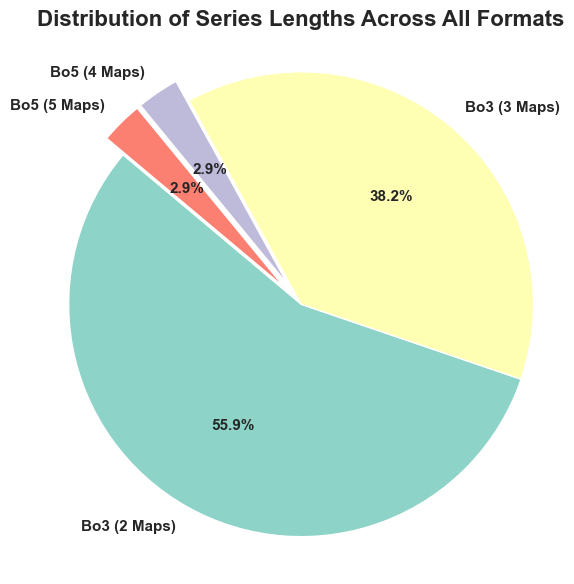

In [761]:
# Distribution of maps played per series ( All formats)

# Create a label combining 'format' and 'maps_played'
# creates categories like "Bo3 (2 Maps)" or "Bo5 (5 Maps)"
matches_overview_df['series_category'] = matches_overview_df['format'] + " (" + matches_overview_df['maps_played'].astype(str) + " Maps)"

# Get the frequency of each category
distribution = matches_overview_df['series_category'].value_counts()

# 4. Generate the Pie Chart
plt.figure(figsize=(6,6))
colors = plt.cm.Set3.colors
# Explode Bo5 categories slightly to make them more visible (slightly highlights BO5 by moving the section outword )
explode = [0.1 if 'Bo5' in label else 0 for label in distribution.index]

plt.pie(
    distribution, 
    labels=distribution.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    explode=explode,
    textprops={'weight': 'bold', 'size': 11}
)

plt.title('Distribution of Series Lengths Across All Formats', weight='bold', size=16)
plt.axis('equal') 
plt.tight_layout()
plt.show()


### Segregate the BO3 matches in a seperated df and count each action 

In [762]:
# map pick & ban frequency for Bo3
df_bo3 = matches_overview_df[matches_overview_df['format'] == 'Bo3'] 

counts = pd.DataFrame({
    "Team_1_ban1" : df_bo3['team1_ban1'].value_counts(),
    "Team_2_ban1" : df_bo3['team2_ban1'].value_counts(),
    "Team_1_pick" :(df_bo3['team1_pick1']).value_counts(),
    "Team_2_pick" : (df_bo3['team2_pick1']).value_counts(),
    "Team_1_ban2" : df_bo3['team1_ban2'].value_counts(),
    "Team_2_ban2" : df_bo3['team2_ban2'].value_counts(),
    "Decider" : (df_bo3['decider']).value_counts()}).fillna(0).astype(int)

counts

,Team_1_ban1,Team_2_ban1,Team_1_pick,Team_2_pick,Team_1_ban2,Team_2_ban2,Decider
Abyss,0,2,4,4,10,8,4
Ascent,4,9,1,2,6,7,3
Bind,8,1,5,5,4,2,7
Haven,5,2,5,3,6,7,4
Icebox,11,5,7,3,1,3,2
Lotus,0,6,6,8,4,1,7
Sunset,4,7,4,7,1,4,5


### Calaculate the pick/ban frequency of the for each map 

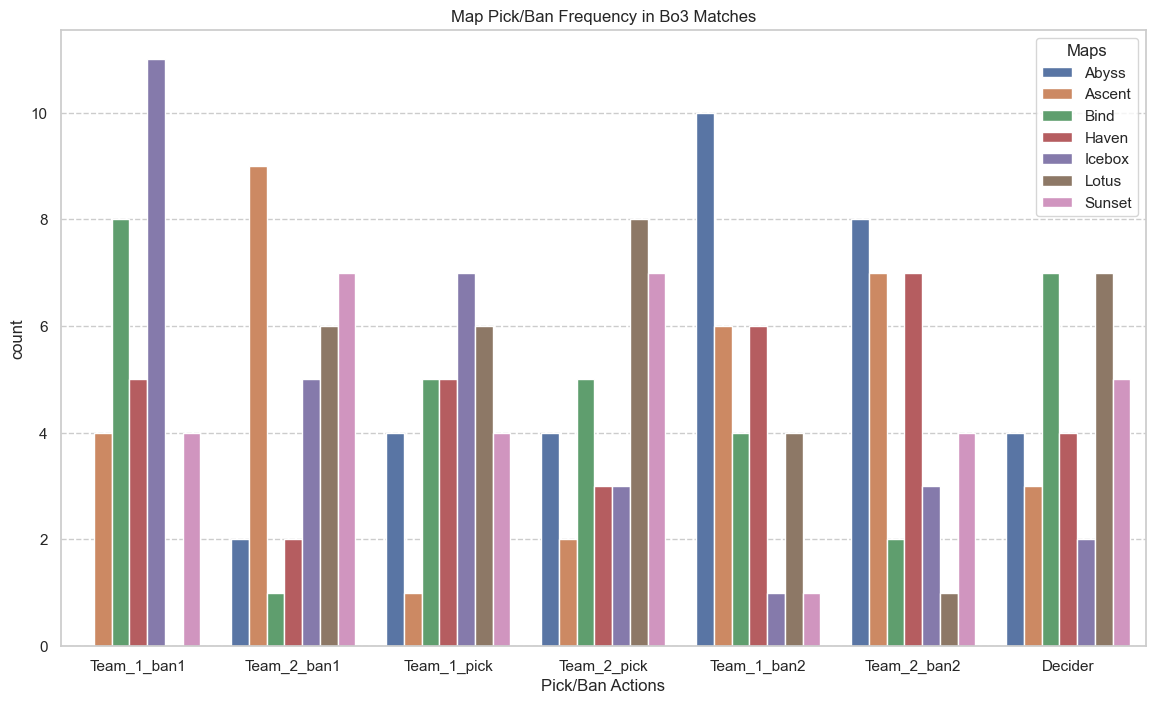

In [763]:
# count the pick / ban frequency of the Bo3 matches
counts_long = counts.reset_index().melt(id_vars = 'index', var_name = 'action', value_name = 'count').rename(columns = {'index':'Maps'})

plt.figure(figsize=(14, 8))
sns.barplot(x = 'action', y = 'count', hue = 'Maps', data = counts_long )
plt.title("Map Pick/Ban Frequency in Bo3 Matches")
plt.xlabel("Pick/Ban Actions")
plt.grid(True,linestyle='--', axis='y' )
plt.show()

Calculate the matches played by each team

In [764]:
# Calculate matches played by each team
team1_col = df_bo3[['team1']].rename(columns={'team1': 'team'})
team2_col = df_bo3[['team2']].rename(columns = {'team2':'team'})
teams = pd.concat((team1_col, team2_col))
df_matches_played = teams.groupby('team').size().reset_index(name ='matches played')
df_matches_played.set_index('team', inplace = True)
df_matches_played

,matches played
team,
Bilibili Gaming,2
DRX,5
EDward Gaming,6
FNATIC,6
FUT Esports,2
FunPlus Phoenix,2
G2 Esports,4
Gen.G,3
KRÜ Esports,3


Calculate the most banned map for each team

In [765]:
#most banned map for each team
df_team1_bans = df_bo3[['team1', 'team1_ban1','team1_ban2']].copy()
df_team1_long = pd.melt(
    df_team1_bans,
    id_vars = ['team1'],
    value_vars=['team1_ban1', 'team1_ban2'],
    var_name = 'ban_type',
    value_name = 'map'
).rename(columns = {'team1':'team'})

df_team2_bans =df_bo3[['team2', 'team2_ban1', 'team2_ban2']].copy()
df_team2_long = pd.melt(
    df_team2_bans,
    id_vars = ['team2'],
    value_vars = ['team2_ban1', 'team2_ban2'],
    var_name = 'ban_type',
    value_name = 'map'
).rename(columns = {'team2':'team'})

df_team_bans = pd.concat([df_team1_long, df_team2_long], ignore_index= True) # By default, pandas keeps the original row indices from each DataFrame
#ignore_index=True resets the index in the new DataFrame without duplicating or preserving the old indices.


In [766]:
df_team1_long

,team,ban_type,map
0,Sentinels,team1_ban1,Icebox
1,FunPlus Phoenix,team1_ban1,Sunset
2,KRÜ Esports,team1_ban1,Icebox
3,Bilibili Gaming,team1_ban1,Haven
4,TALON,team1_ban1,Icebox
...,...,...,...
59,LEVIATÁN,team1_ban2,Abyss
60,Sentinels,team1_ban2,Abyss
61,DRX,team1_ban2,Lotus
62,LEVIATÁN,team1_ban2,Haven


In [767]:
df_team2_long

,team,ban_type,map
0,Gen.G,team2_ban1,Sunset
1,Team Heretics,team2_ban1,Icebox
2,DRX,team2_ban1,Lotus
3,FNATIC,team2_ban1,Sunset
4,LEVIATÁN,team2_ban1,Lotus
...,...,...,...
59,Team Heretics,team2_ban2,Sunset
60,FNATIC,team2_ban2,Ascent
61,Team Heretics,team2_ban2,Haven
62,EDward Gaming,team2_ban2,Sunset


In [768]:
df_team_bans

,team,ban_type,map
0,Sentinels,team1_ban1,Icebox
1,FunPlus Phoenix,team1_ban1,Sunset
2,KRÜ Esports,team1_ban1,Icebox
3,Bilibili Gaming,team1_ban1,Haven
4,TALON,team1_ban1,Icebox
...,...,...,...
123,Team Heretics,team2_ban2,Sunset
124,FNATIC,team2_ban2,Ascent
125,Team Heretics,team2_ban2,Haven
126,EDward Gaming,team2_ban2,Sunset


### Calculate the ban percentage for each team on each map 
1. Clean the different ban stages into one
2. Pivot the table to have the team as index and maps as columns


In [769]:
# Clean the ban stages
df_team_bans['ban_stage'] = df_team_bans['ban_type'].apply(
    lambda x : 'Ban' if x =='team1_ban1' or x == 'team2_ban1' or x == 'team1_ban2' or x == 'team2_ban2' else "other"
)
df_team_bans.drop(columns = ['ban_type'], inplace = True)

# Calculate the most banned map for each team
most_banned_maps = df_team_bans.groupby(['team', 'map']).size().reset_index(name='ban_count')
most_banned_maps = most_banned_maps.sort_values(['team', 'ban_count'], ascending=[True, False])

#pivot the dataframe to get the maps as cols and teams as index
df_banned_maps = most_banned_maps.pivot_table(index = 'team', columns = 'map', values = 'ban_count', fill_value = 0)
df_total = pd.DataFrame()
df_total['total_bans'] = df_banned_maps.sum(axis = 1)

# Calculate the ban rate for each map by dividing ban counts by total bans
df_banned_maps = (df_banned_maps.div(df_total['total_bans'], axis=0))
df_banned_maps = df_banned_maps.round(2)

# Add matches played column to the banned maps dataframe
df_banned_maps= df_banned_maps.join(df_matches_played)

df_banned_maps 


,Abyss,Ascent,Bind,Haven,Icebox,Lotus,Sunset,matches played
team,,,,,,,,
Bilibili Gaming,0.25,0.25,0.00,0.50,0.00,0.00,0.00,2
DRX,0.10,0.20,0.10,0.20,0.00,0.30,0.10,5
EDward Gaming,0.17,0.50,0.08,0.00,0.17,0.00,0.08,6
FNATIC,0.08,0.17,0.00,0.00,0.50,0.00,0.25,6
FUT Esports,0.50,0.00,0.00,0.50,0.00,0.00,0.00,2
FunPlus Phoenix,0.00,0.25,0.00,0.25,0.00,0.00,0.50,2
G2 Esports,0.12,0.25,0.00,0.00,0.00,0.12,0.50,4
Gen.G,0.00,0.00,0.17,0.17,0.00,0.17,0.50,3
KRÜ Esports,0.33,0.17,0.33,0.00,0.17,0.00,0.00,3


### Plot a heatmap showcasing the ban % for each team for each team on each map

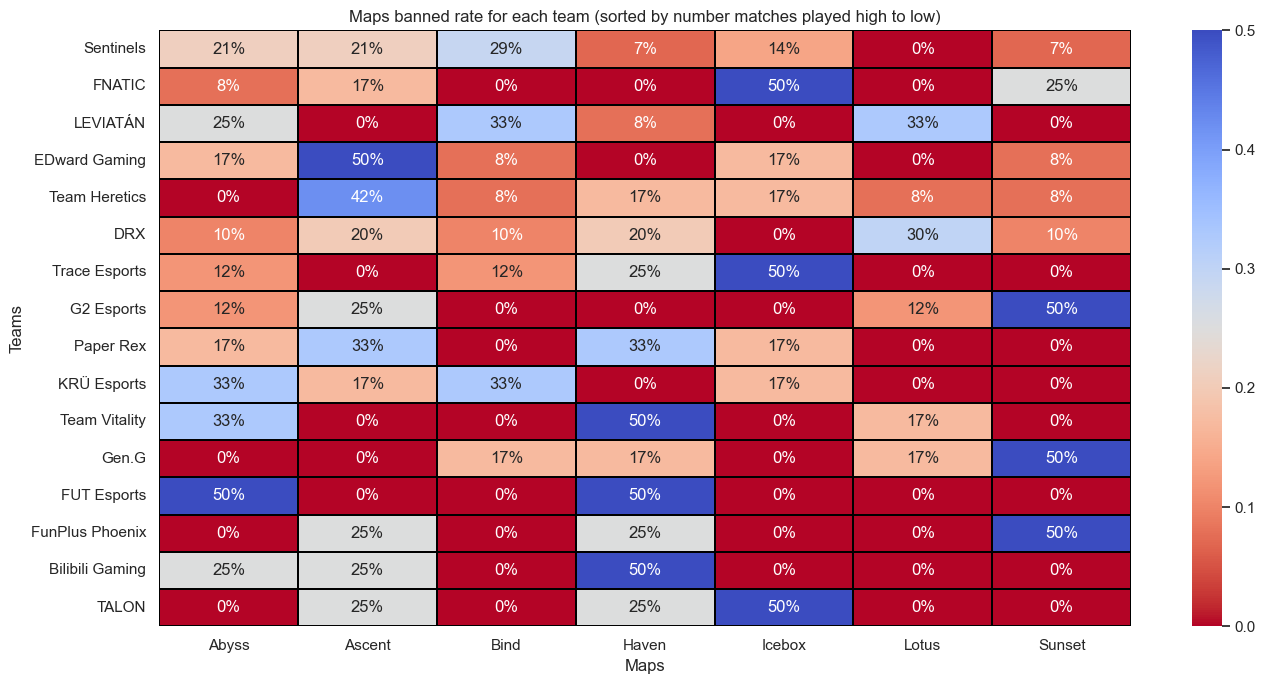

In [770]:
# visualize the ban rate for each map for each team sorted by number of matches played

#Sort values by the matches played
df_banned_maps= df_banned_maps.sort_values( by = 'matches played', ascending = False)

# selecting the matches columns 
map_cols = [cols for cols in df_banned_maps.columns if cols != 'matches played']

plt.figure(figsize = (14, 7))
sns.heatmap(df_banned_maps[map_cols], cmap = 'coolwarm_r', linewidth = 0.2, linecolor = 'black', annot = True, xticklabels= True, yticklabels= True, fmt = ".0%")

plt.title("Maps banned rate for each team (sorted by number matches played high to low)")
plt.ylabel("Teams")
plt.xlabel("Maps")
plt.tight_layout()
plt.show()


In [771]:
df_bo3.head()

,match_id,format,maps_played,team1,team2,team1_score,team2_score,winner,looser,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider,series_category
0,378662,Bo3,2,Sentinels,Gen.G,2,0,Gen.G,Sentinels,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss,Bo3 (2 Maps)
1,378663,Bo3,3,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus,Bo3 (3 Maps)
2,378657,Bo3,3,KRÜ Esports,DRX,2,1,DRX,KRÜ Esports,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (3 Maps)
3,378656,Bo3,2,Bilibili Gaming,FNATIC,2,0,FNATIC,Bilibili Gaming,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent,Bo3 (2 Maps)
4,378667,Bo3,2,TALON,LEVIATÁN,2,0,LEVIATÁN,TALON,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset,Bo3 (2 Maps)


### Transform team picks into long format
- Extract pick and decider columns for each team  
- Reshape using `pd.melt` to convert wide → long format  
- Rename team columns for consistency  
- Concatenate Team 1 and Team 2 data into a unified DataFrame (`df_team_picks`)  
- Final result: each row shows a team, pick type, decider, and picked map


In [772]:
# seperate the picks and decider for each team into long format
df_team1_picks = df_bo3[['team1', 'team1_pick1', 'decider']].copy()

df_team1_picks_long = pd.melt(
    df_team1_picks,
    id_vars = ['team1', 'decider'],
    value_vars= ['team1_pick1'],
    var_name = 'pick_type',
    value_name ='picked_map'
).rename(columns = {'team1':'team'})

df_team2_picks = df_bo3[['team2','team2_pick1','decider']].copy()
df_team2_picks_long  = pd.melt(
    df_team2_picks,
    id_vars = ['team2','decider'],
    value_vars = 'team2_pick1',
    var_name = 'pick_type',
    value_name = 'picked_map'
).rename(columns = {'team2':'team'})
df_team2_picks_long

df_team_picks = pd.concat([df_team1_picks_long,df_team2_picks_long], ignore_index = True)
df_team_picks

,team,decider,pick_type,picked_map
0,Sentinels,Abyss,team1_pick1,Haven
1,FunPlus Phoenix,Lotus,team1_pick1,Abyss
2,KRÜ Esports,Bind,team1_pick1,Haven
3,Bilibili Gaming,Ascent,team1_pick1,Bind
4,TALON,Sunset,team1_pick1,Bind
...,...,...,...,...
59,Team Heretics,Haven,team2_pick1,Lotus
60,FNATIC,Lotus,team2_pick1,Bind
61,Team Heretics,Icebox,team2_pick1,Sunset
62,EDward Gaming,Abyss,team2_pick1,Lotus


### Pick & Decider Rates
- Drop `pick_type` column  
- Count picks (`pick_count`) and deciders (`decider_count`) per team/map  
- Merge counts into one DataFrame  
- Pivot to get maps as columns, teams as rows  
- Normalize by matches played → pick/decider rates  
- Round values for readability


In [773]:
# drop the pick_type column
df_team_picks.drop(columns = ['pick_type'], inplace = True)

# Count the maps picked by each team
picks_count = df_team_picks.groupby(['team','picked_map']).size().reset_index(name = 'pick_count')
picks_count = picks_count.rename(columns = {'picked_map':'map'})


# count the decider map for each team
decider_count = df_team_picks.groupby(['team','decider']).size().reset_index(name = 'decider_count')
decider_count = decider_count.rename(columns = {'decider':'map'})

# merge the pick_count and decider_count dataframes
df_counts = pd.merge(picks_count,decider_count, on = ['team','map'], how = 'outer').fillna(0)

#convert the counts to integer
df_counts['pick_count']= df_counts['pick_count'].astype(int)
df_counts['decider_count'] = df_counts['decider_count'].astype(int)


# pivot the dataframe to get pick rate and decider rate separately
df_pick_rate = df_counts.copy()
df_pick_rate = df_pick_rate.drop(columns = [ 'decider_count'])
df_map_picks = df_pick_rate.pivot_table(index = 'team',columns = 'map', values = 'pick_count', fill_value = 0)
df_map_picks = df_map_picks.div(df_map_picks.sum(axis = 1), axis=0)
df_map_picks = df_map_picks.round(2)
df_map_picks = df_map_picks.join(df_matches_played)
df_map_picks = df_map_picks.sort_values(by = 'matches played',ascending = False)
df_map_picks = df_map_picks.drop(columns = ['matches played'])

df_decider_rate = df_counts.copy()
df_decider_rate = df_decider_rate.drop(columns = ['pick_count'])
df_map_deciders = df_decider_rate.pivot_table(index = 'team', columns = 'map', values = 'decider_count', fill_value = 0)
df_map_deciders = df_map_deciders.div(df_map_deciders.sum(axis=1), axis=0)
df_map_deciders = df_map_deciders.round(2)
df_map_deciders = df_map_deciders.join(df_matches_played)
df_map_deciders = df_map_deciders.sort_values(by = 'matches played', ascending = False)
df_map_deciders = df_map_deciders.drop(columns = ['matches played'])


In [774]:
df_counts

,team,map,pick_count,decider_count
0,Bilibili Gaming,Ascent,0,1
1,Bilibili Gaming,Bind,1,0
2,Bilibili Gaming,Icebox,1,0
3,Bilibili Gaming,Sunset,0,1
4,DRX,Abyss,4,0
...,...,...,...,...
64,Team Vitality,Sunset,3,0
65,Trace Esports,Ascent,1,1
66,Trace Esports,Bind,2,1
67,Trace Esports,Lotus,1,1


In [775]:
df_pick_rate

,team,map,pick_count
0,Bilibili Gaming,Ascent,0
1,Bilibili Gaming,Bind,1
2,Bilibili Gaming,Icebox,1
3,Bilibili Gaming,Sunset,0
4,DRX,Abyss,4
...,...,...,...
64,Team Vitality,Sunset,3
65,Trace Esports,Ascent,1
66,Trace Esports,Bind,2
67,Trace Esports,Lotus,1


In [776]:
df_map_picks

,Abyss,Ascent,Bind,Haven,Icebox,Lotus,Sunset
team,,,,,,,
Sentinels,0.00,0.00,0.00,0.29,0.00,0.43,0.29
FNATIC,0.00,0.00,0.17,0.33,0.00,0.50,0.00
LEVIATÁN,0.00,0.17,0.00,0.00,0.67,0.00,0.17
EDward Gaming,0.00,0.00,0.17,0.33,0.17,0.17,0.17
Team Heretics,0.33,0.00,0.17,0.00,0.17,0.17,0.17
DRX,0.80,0.00,0.00,0.20,0.00,0.00,0.00
Trace Esports,0.00,0.25,0.50,0.00,0.00,0.25,0.00
G2 Esports,0.25,0.00,0.25,0.00,0.25,0.25,0.00
Paper Rex,0.00,0.00,0.33,0.00,0.33,0.00,0.33


In [777]:
df_map_deciders

,Abyss,Ascent,Bind,Haven,Icebox,Lotus,Sunset
team,,,,,,,
Sentinels,0.43,0.00,0.00,0.14,0.14,0.14,0.14
FNATIC,0.00,0.17,0.17,0.17,0.00,0.50,0.00
LEVIATÁN,0.17,0.33,0.00,0.33,0.00,0.00,0.17
EDward Gaming,0.17,0.00,0.17,0.00,0.00,0.33,0.33
Team Heretics,0.17,0.00,0.17,0.33,0.17,0.17,0.00
DRX,0.00,0.00,0.40,0.00,0.40,0.00,0.20
Trace Esports,0.00,0.25,0.25,0.00,0.00,0.25,0.25
G2 Esports,0.00,0.00,0.50,0.25,0.00,0.25,0.00
Paper Rex,0.00,0.00,0.33,0.00,0.00,0.67,0.00


### Map Pick Rate Heatmap
This heatmap shows how often each team picked different maps, normalized by matches played.  
Teams are listed on the y-axis, maps on the x-axis, and values are shown as percentages.


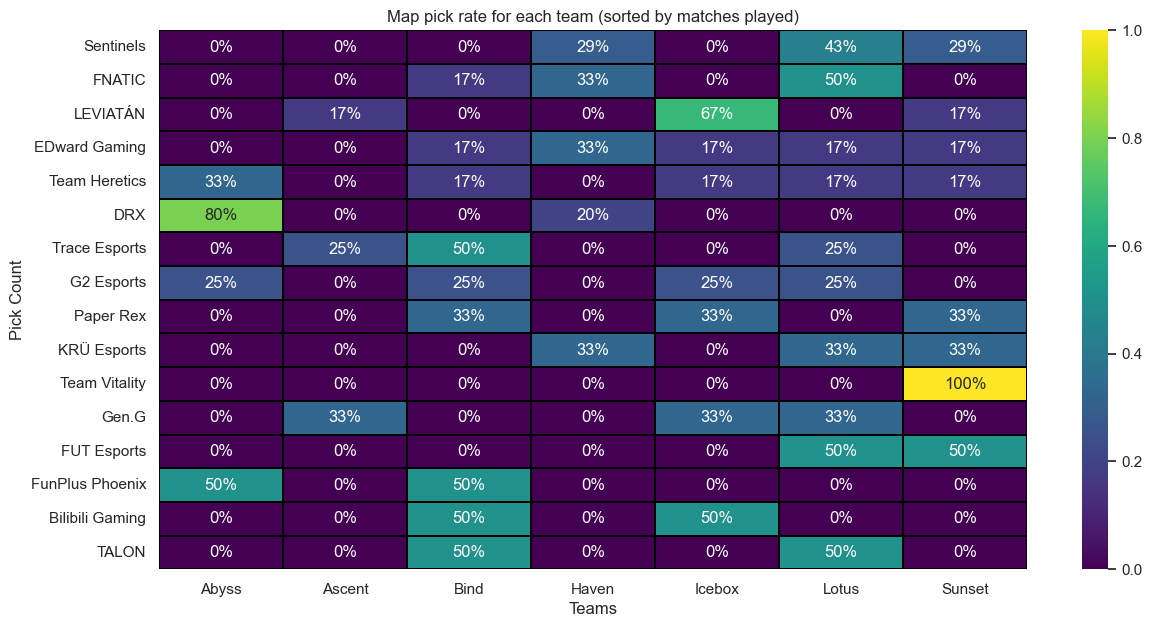

In [778]:
#visualize the pick rate of maps for each team
plt.figure(figsize = (14,7))
sns.heatmap(df_map_picks,cmap = 'viridis', linewidths= 0.3, linecolor= 'black', annot = True, xticklabels= True, yticklabels= True, fmt = ".0%")
plt.title("Map pick rate for each team (sorted by matches played)")
plt.xlabel('Teams')
plt.ylabel('Pick Count')
plt.grid(axis = 'y', linestyle = ':', linewidth = 0.7)
plt.show()

### Decider Map Rate Heatmap
This heatmap shows how often each team had different maps as deciders, normalized by matches played.  
Teams are listed on the y-axis, maps on the x-axis, and values are shown as percentages.


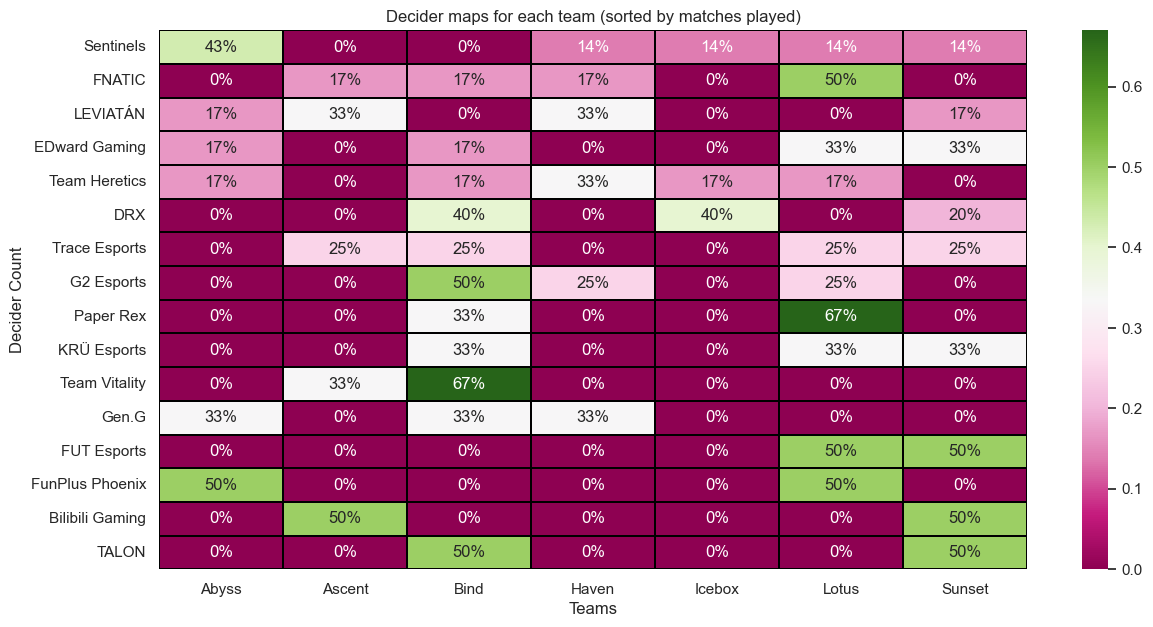

In [779]:
# visualize the decider rate of maps for each team
plt.figure(figsize = (14,7))
sns.heatmap(df_map_deciders,cmap = 'PiYG', linewidths= 0.3, linecolor= 'black', annot = True, xticklabels= True, yticklabels= True, fmt = ".0%")
plt.title("Decider maps for each team (sorted by matches played)")
plt.xlabel('Teams')
plt.ylabel('Decider Count')
plt.grid(axis = 'y', linestyle = ':', linewidth = 0.7)
plt.show()

In [780]:
matches_maps_df

,match_id,map_name,map_order,score,winner,duration,picked_by
0,378662,Haven,1,13 - 8,Gen.G,1:02:40,Sentinels
1,378662,Ascent,2,13 - 7,Gen.G,46:45,Gen.G
2,378663,Abyss,1,12 - 14,Team Heretics,1:10:12,FunPlus Phoenix
3,378663,Bind,2,13 - 9,FunPlus Phoenix,53:01,Team Heretics
4,378663,Lotus,3,13 - 15,Team Heretics,1:07:12,Decider
...,...,...,...,...,...,...,...
81,378829,Haven,1,6 - 13,Team Heretics,1:16:43,EDward Gaming
82,378829,Sunset,2,13 - 4,EDward Gaming,45:11,Team Heretics
83,378829,Lotus,3,13 - 9,EDward Gaming,55:30,EDward Gaming
84,378829,Bind,4,11 - 13,Team Heretics,1:01:45,Team Heretics


### Map Pick vs Win Rates (Summary)
- Built dataset with map name, picking team, and winner  
- Added `win_count` (1 if picking team won, else 0)  
- Removed decider maps from analysis   
- Summarize table showing pick frequency and win success per map


In [781]:
# Map Pick vs Win Rates
df_win_rates = matches_maps_df[['map_name', 'picked_by', 'winner']].copy()
df_win_rates['win_count'] = (df_win_rates['picked_by']== df_win_rates['winner']).astype(int)
df_win_rates = df_win_rates[df_win_rates['picked_by'] != 'Decider']
all_maps = df_win_rates['map_name'].unique()

df_win_rates_summary = df_win_rates.groupby('map_name').agg(
    total_picks = ('picked_by', 'count'),
    wins_by_picking_team = ('win_count', 'sum')
).reset_index()

In [782]:
df_win_rates

,map_name,picked_by,winner,win_count
0,Haven,Sentinels,Gen.G,0
1,Ascent,Gen.G,Gen.G,1
2,Abyss,FunPlus Phoenix,Team Heretics,0
3,Bind,Team Heretics,FunPlus Phoenix,0
5,Haven,KRÜ Esports,KRÜ Esports,1
...,...,...,...,...
80,Lotus,Team Heretics,Team Heretics,1
81,Haven,EDward Gaming,Team Heretics,0
82,Sunset,Team Heretics,EDward Gaming,0
83,Lotus,EDward Gaming,EDward Gaming,1


In [783]:
# Win rate for each map when picked
df_win_rates_summary['pick_rate'] = (df_win_rates_summary['total_picks']/df_win_rates_summary['total_picks'].sum() * 100).round(2)
df_win_rates_summary['win_rate'] = (df_win_rates_summary['wins_by_picking_team']/df_win_rates_summary['total_picks'] * 100).round(2)
df_win_rates_summary

,map_name,total_picks,wins_by_picking_team,pick_rate,win_rate
0,Abyss,9,6,12.50,66.67
1,Ascent,3,3,4.17,100.00
2,Bind,11,5,15.28,45.45
3,Haven,9,4,12.50,44.44
4,Icebox,11,5,15.28,45.45
5,Lotus,16,8,22.22,50.00
6,Sunset,13,9,18.06,69.23


In [784]:
df_win_rates_summary.sort_values( by = 'pick_rate', ascending = False, inplace = True)
df_win_rates_summary.drop(columns = ['total_picks', 'wins_by_picking_team'], inplace = True)#df_win_rates_summary.set_index(['map_name'], inplace = True)
df_win_rates_summary

,map_name,pick_rate,win_rate
5,Lotus,22.22,50.00
6,Sunset,18.06,69.23
2,Bind,15.28,45.45
4,Icebox,15.28,45.45
0,Abyss,12.50,66.67
3,Haven,12.50,44.44
1,Ascent,4.17,100.00


In [785]:
print(df_win_rates_summary.columns)

Index(['map_name', 'pick_rate', 'win_rate'], dtype='object')


### Win Rate vs Pick Rate
This chart compares how often each map is picked (blue bars) with how successful teams are when picking it (red line).  
Maps are shown on the x-axis, while pick and win rates (in %) are on the y-axis.  
It highlights which maps are popular choices and whether picking them tends to lead to wins.

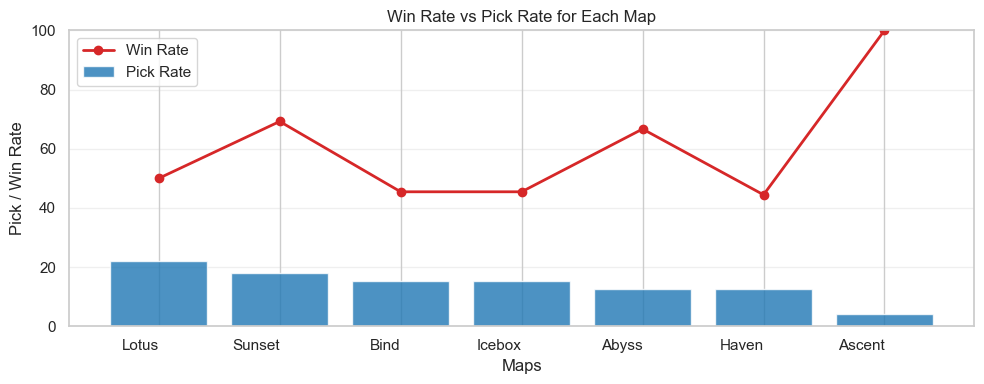

In [786]:

maps = df_win_rates_summary['map_name']
x = np.arange(len(maps))

fig, ax = plt.subplots(figsize=(10, 4))

# Bar plot → Pick Rate
ax.bar(
    x,
    df_win_rates_summary["pick_rate"],
    alpha=0.8,
    label="Pick Rate",
    color="tab:blue"
)


# Line plot → Win Rate
ax.plot(
    x,
    df_win_rates_summary["win_rate"],
    color="tab:red",
    marker="o",
    linewidth=2,
    label="Win Rate"
)

# Axis formatting

ax.set_xticks(x)
ax.set_xticklabels(maps, ha="right")

ax.set_title("Win Rate vs Pick Rate for Each Map")
ax.set_xlabel("Maps")
ax.set_ylabel("Pick / Win Rate")
ax.set_ylim(0, 100)

ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [787]:
# Map win rate for each team on their map picks
# aagregate per team per map
team_map = (
    df_win_rates.groupby(["picked_by", "map_name"])
      .agg(
          picked_count=("map_name", "count"),
          wins_count=("win_count", "sum")
      )
      .reset_index()
      .rename(columns={
          "picked_by": "team",
          "map_name": "map"
      })
)
team_map

,team,map,picked_count,wins_count
0,Bilibili Gaming,Bind,1,0
1,Bilibili Gaming,Icebox,1,0
2,DRX,Abyss,4,4
3,DRX,Haven,1,0
4,EDward Gaming,Bind,1,1
5,EDward Gaming,Haven,3,0
6,EDward Gaming,Icebox,1,0
7,EDward Gaming,Lotus,2,2
8,EDward Gaming,Sunset,1,1
9,FNATIC,Bind,1,1


### Team–Map Reindexing
To ensure consistency, we build a complete team × map index so every possible combination exists in the dataset.  
- Create a `MultiIndex` of all teams and all maps  
- Reindex the existing data against this full index  
- Fill missing combinations with 0 (so teams that never picked/played a map are still represented)  
- Reset the index back into columns for easier use later  

This guarantees that downstream calculations (pick rate, win rate, visualizations) won’t break due to missing rows.

In [809]:
#
all_teams = team_map["team"].unique()

full_index = pd.MultiIndex.from_product(
    [all_teams, all_maps],
    names=["team", "map"]
)

team_map = (
    team_map
    .set_index(["team", "map"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

In [810]:
# total map picks per team and rank them by total picks

team_total_picks = (
    team_map.groupby("team")["picked_count"]
    .sum()
    .sort_values(ascending=False)
)

teams_sorted = team_total_picks.index.tolist()
n_teams = len(teams_sorted)

In [811]:
# calculate the pick rate and win rate for each map for each team
team_map["total_picks_team"] = team_map["team"].map(team_total_picks)

# Zero-safe pick rate
team_map["pick_rate"] = np.where(
    team_map["total_picks_team"] > 0,
    team_map["picked_count"] / team_map["total_picks_team"],
    0
)

# Zero-safe win rate
team_map["win_rate"] = np.where(
    team_map["picked_count"] > 0,
    team_map["wins_count"] / team_map["picked_count"],
    0
)

team_map

,team,map,picked_count,wins_count,total_picks_team,pick_rate,win_rate
0,Bilibili Gaming,Haven,0,0,2,0.00,0.0
1,Bilibili Gaming,Ascent,0,0,2,0.00,0.0
2,Bilibili Gaming,Abyss,0,0,2,0.00,0.0
3,Bilibili Gaming,Bind,1,0,2,0.50,0.0
4,Bilibili Gaming,Lotus,0,0,2,0.00,0.0
...,...,...,...,...,...,...,...
107,Trace Esports,Abyss,0,0,4,0.00,0.0
108,Trace Esports,Bind,2,1,4,0.50,0.5
109,Trace Esports,Lotus,1,0,4,0.25,0.0
110,Trace Esports,Sunset,0,0,4,0.00,0.0


### Team Map Pick vs Win Rates
This grid of plots shows each team’s pick rate (blue bars) and win rate (red line) across maps.  
Teams are displayed in separate subplots, with maps on the x-axis and rates (0–1) on the y-axis.  
It highlights how often teams pick certain maps and how successful they are on those picks.

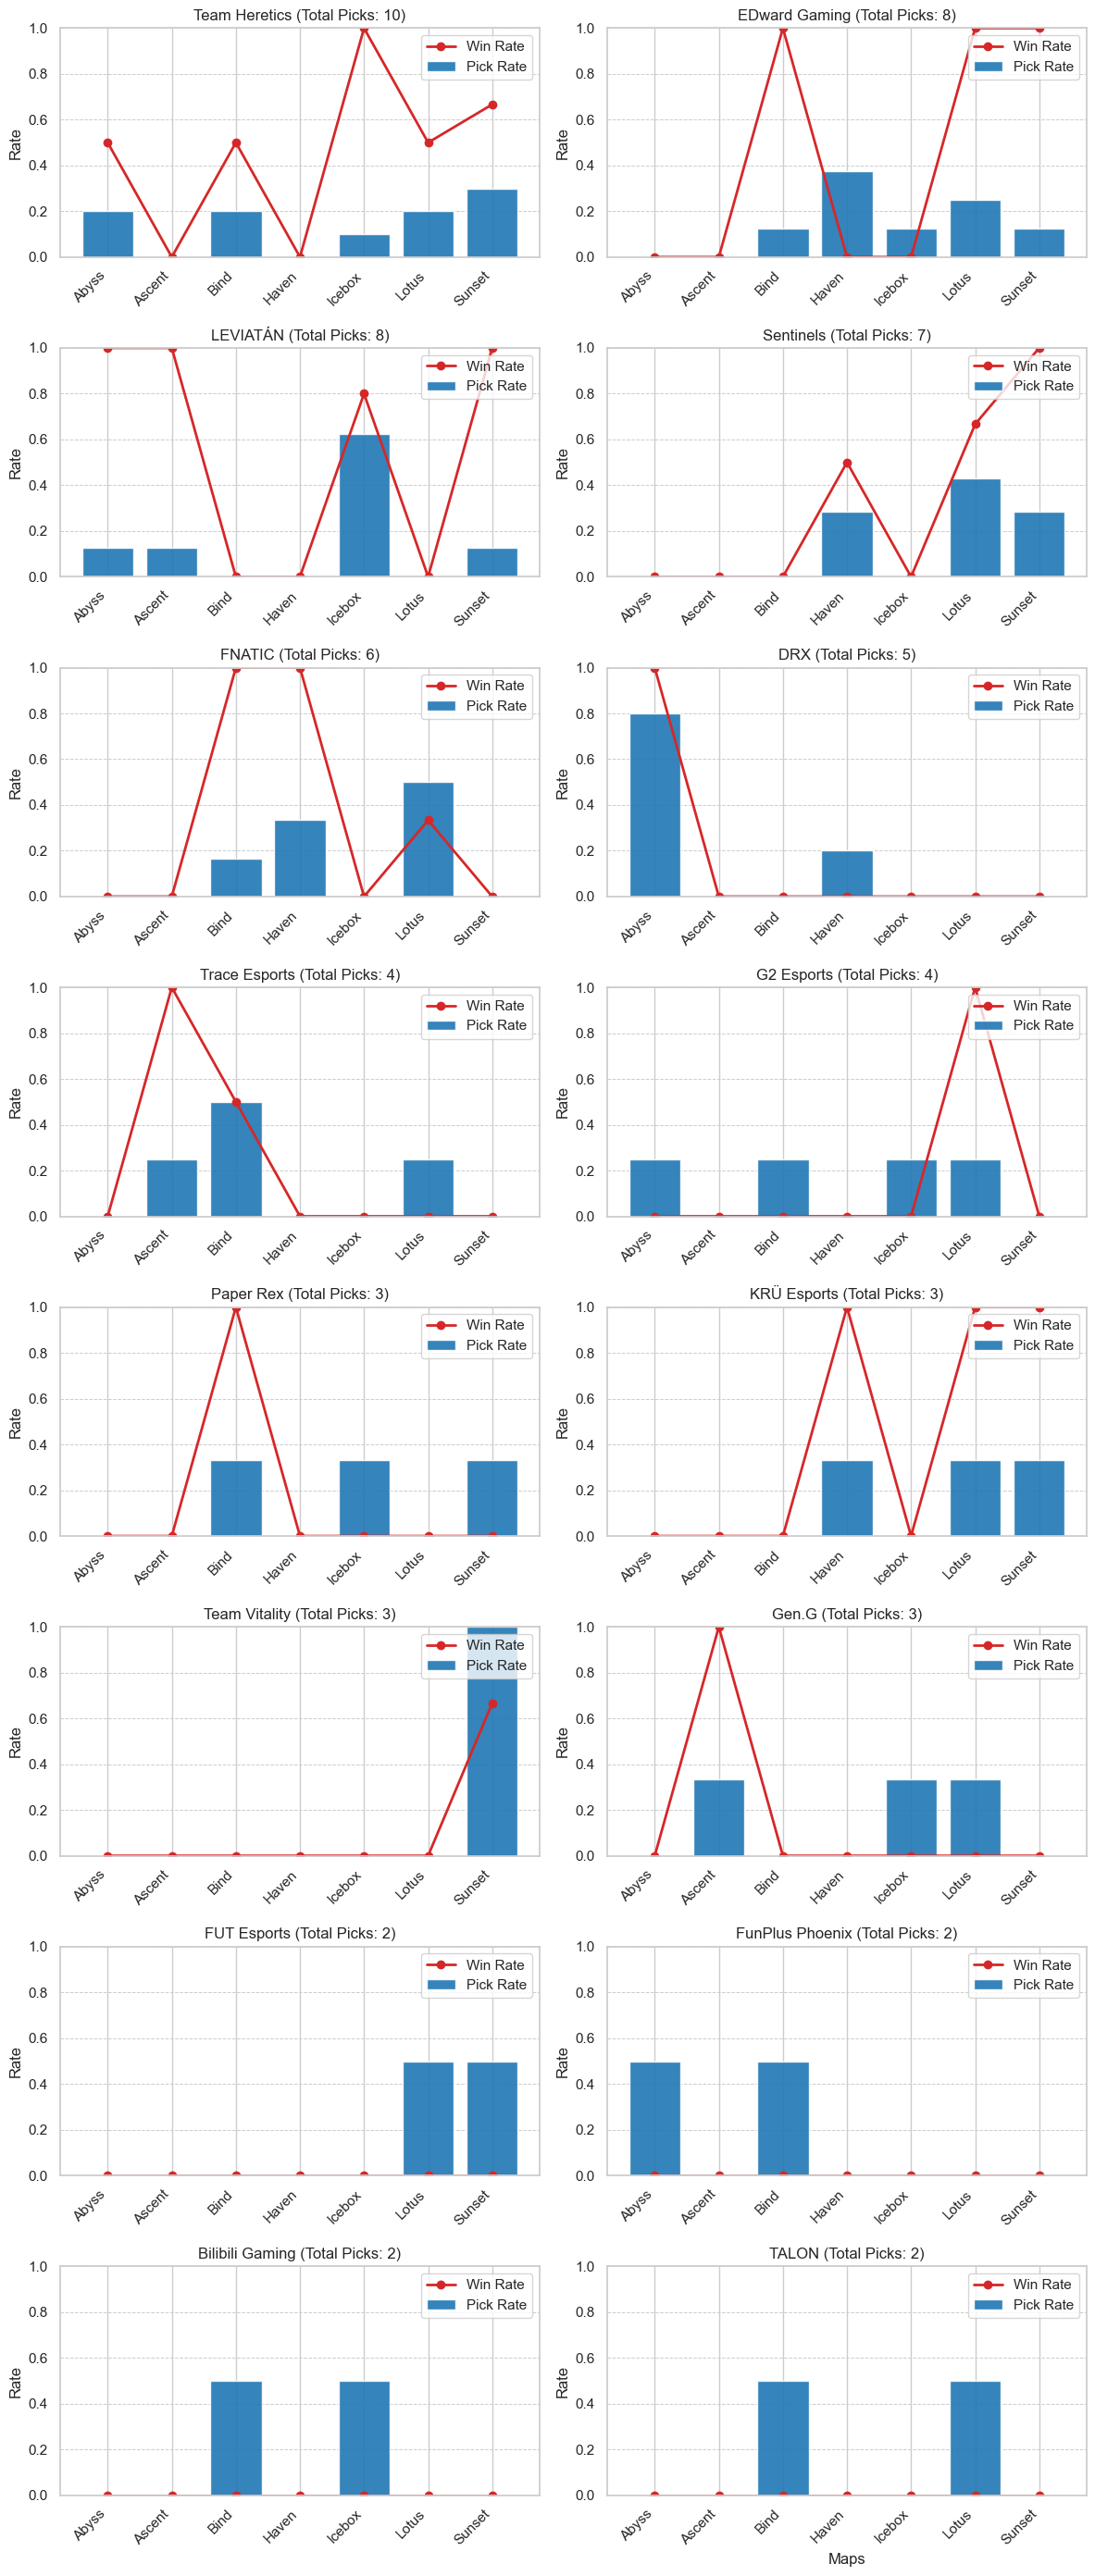

In [791]:
# calculate the total number of teams
ncols = 2
nrows = math.ceil(n_teams / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 3.5 * nrows),
    sharex=False
)

axes = axes.flatten()

# plot for each team

for ax, team in zip(axes, teams_sorted):
    team_df = team_map[team_map["team"] == team]

    #Consistent map ordering across all teams
    team_df = team_df.sort_values("map")

    maps = team_df["map"]
    x = np.arange(len(maps))

    # Win rate bars
    ax.bar(
        x,
        team_df["pick_rate"],
        alpha=0.9,
        label="Pick Rate",
        color = 'tab:blue'
    )

    # Pick rate line
    ax.plot(
        x,
        team_df["win_rate"],
        marker="o",
        linewidth=2,
        label="Win Rate",
        color = 'tab:red'
    )

    ax.set_xticks(x)
    ax.set_xticklabels(maps, rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle = '--', axis = 'y', linewidth = 0.7)
    ax.set_ylabel("Rate")
    ax.set_title(f"{team} (Total Picks: {team_total_picks[team]})")
    ax.legend(loc="upper right")

    for i in range(len(teams_sorted), len(axes)):
        fig.delaxes(axes[i])

plt.xlabel("Maps")
plt.tight_layout()
plt.show()

In [792]:
matches_maps_df

,match_id,map_name,map_order,score,winner,duration,picked_by
0,378662,Haven,1,13 - 8,Gen.G,1:02:40,Sentinels
1,378662,Ascent,2,13 - 7,Gen.G,46:45,Gen.G
2,378663,Abyss,1,12 - 14,Team Heretics,1:10:12,FunPlus Phoenix
3,378663,Bind,2,13 - 9,FunPlus Phoenix,53:01,Team Heretics
4,378663,Lotus,3,13 - 15,Team Heretics,1:07:12,Decider
...,...,...,...,...,...,...,...
81,378829,Haven,1,6 - 13,Team Heretics,1:16:43,EDward Gaming
82,378829,Sunset,2,13 - 4,EDward Gaming,45:11,Team Heretics
83,378829,Lotus,3,13 - 9,EDward Gaming,55:30,EDward Gaming
84,378829,Bind,4,11 - 13,Team Heretics,1:01:45,Team Heretics


### Decider Maps Analysis
Filter out matches where the map was a decider, merge with match overview to get winner/loser, and clean up columns for a clear dataset.


In [793]:
# pick / win rate on decider maps
decider_maps = matches_maps_df[['match_id','map_name', 'picked_by','winner']].copy()
decider_maps = decider_maps[decider_maps['picked_by'] == 'Decider']
decider_maps = decider_maps.rename(columns = {'winner':'winning_team'})
# get the match_id, winner, looser from matches_overview_df

decider_maps = pd.merge(decider_maps, matches_overview_df[['match_id','winner', 'looser']], left_on = 'match_id', right_on= 'match_id', how = 'left')

decider_maps.drop(columns = ['picked_by','winning_team'], inplace = True)
decider_maps

,match_id,map_name,winner,looser
0,378663,Lotus,Team Heretics,FunPlus Phoenix
1,378657,Bind,DRX,KRÜ Esports
2,378669,Bind,Trace Esports,Team Vitality
3,378664,Bind,Team Heretics,Gen.G
4,378670,Ascent,Trace Esports,LEVIATÁN
5,378675,Bind,G2 Esports,EDward Gaming
6,378660,Lotus,FNATIC,KRÜ Esports
7,378677,Lotus,EDward Gaming,Paper Rex
8,378826,Sunset,EDward Gaming,Sentinels
9,378834,Lotus,Sentinels,FNATIC


In [794]:
decider_map_count = decider_maps['map_name'].copy()
decider_map_count= decider_map_count.value_counts()
decider_map_count

map_name
Lotus     4
Bind      4
Abyss     3
Ascent    1
Sunset    1
Icebox    1
Name: count, dtype: int64

### Decider Map Counts
Manually add Haven with count 0 (since it was never a decider), then plot a bar chart showing how often each map was played as a decider.


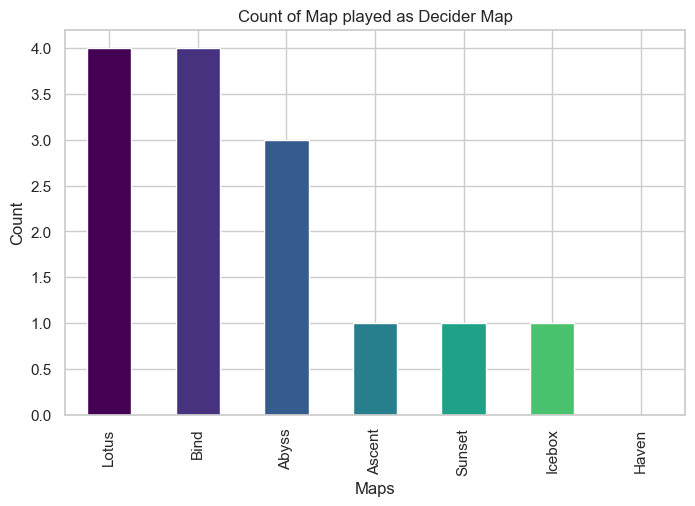

In [795]:
#Since Haven is not played on decide map, we will add it manually with count 0

decider_map_count['Haven'] = 0

# Choose gradient coloer based on index
cmap = plt.get_cmap('viridis')
colors = [cmap(i / len(decider_map_count)) for i in range (len(decider_map_count))]

#visualize the decider map count
decider_map_count.plot(kind = 'bar', figsize = (8, 5), color = colors)
plt.title("Count of Map played as Decider Map")
plt.ylabel('Count')
plt.xlabel("Maps")
plt.show()

### Win Rates on Decider Maps
Reshape the data to combine winners and losers into one column (`team`),  
mark wins with a flag, then group by team and map to calculate total games, wins, and win rate (%).

In [796]:
# combine both the cols of winner and looser into one col  - team
decider_map_long = pd.melt(
    decider_maps,
    id_vars = ['match_id', 'map_name'],
    value_vars = ['winner','looser'],
    var_name = 'result_type',
    value_name = 'team'
)

# calculate win rate on decider maps
decider_map_long['win_count'] = np.where(decider_map_long['result_type'] == 'winner', 1, 0)
decider_map_long
decider_map_stats = decider_map_long.groupby(['team', 'map_name']).agg(
    wins = ('win_count','sum'),
    total = ('win_count', 'count')
).reset_index()

decider_map_stats['win_rate'] = (decider_map_stats['wins'] / decider_map_stats['total']) * 100
decider_map_stats

,team,map_name,wins,total,win_rate
0,DRX,Bind,1,1,100.0
1,DRX,Icebox,0,1,0.0
2,EDward Gaming,Abyss,2,2,100.0
3,EDward Gaming,Bind,0,1,0.0
4,EDward Gaming,Lotus,1,1,100.0
5,EDward Gaming,Sunset,1,1,100.0
6,FNATIC,Lotus,1,2,50.0
7,FunPlus Phoenix,Lotus,0,1,0.0
8,G2 Esports,Bind,1,1,100.0
9,Gen.G,Bind,0,1,0.0


### Win Rates on Decider Maps
This visualization shows each team’s win rate on decider maps, broken down by map.  
Each subplot represents a map, with bars for teams and annotated percentages for clarity.


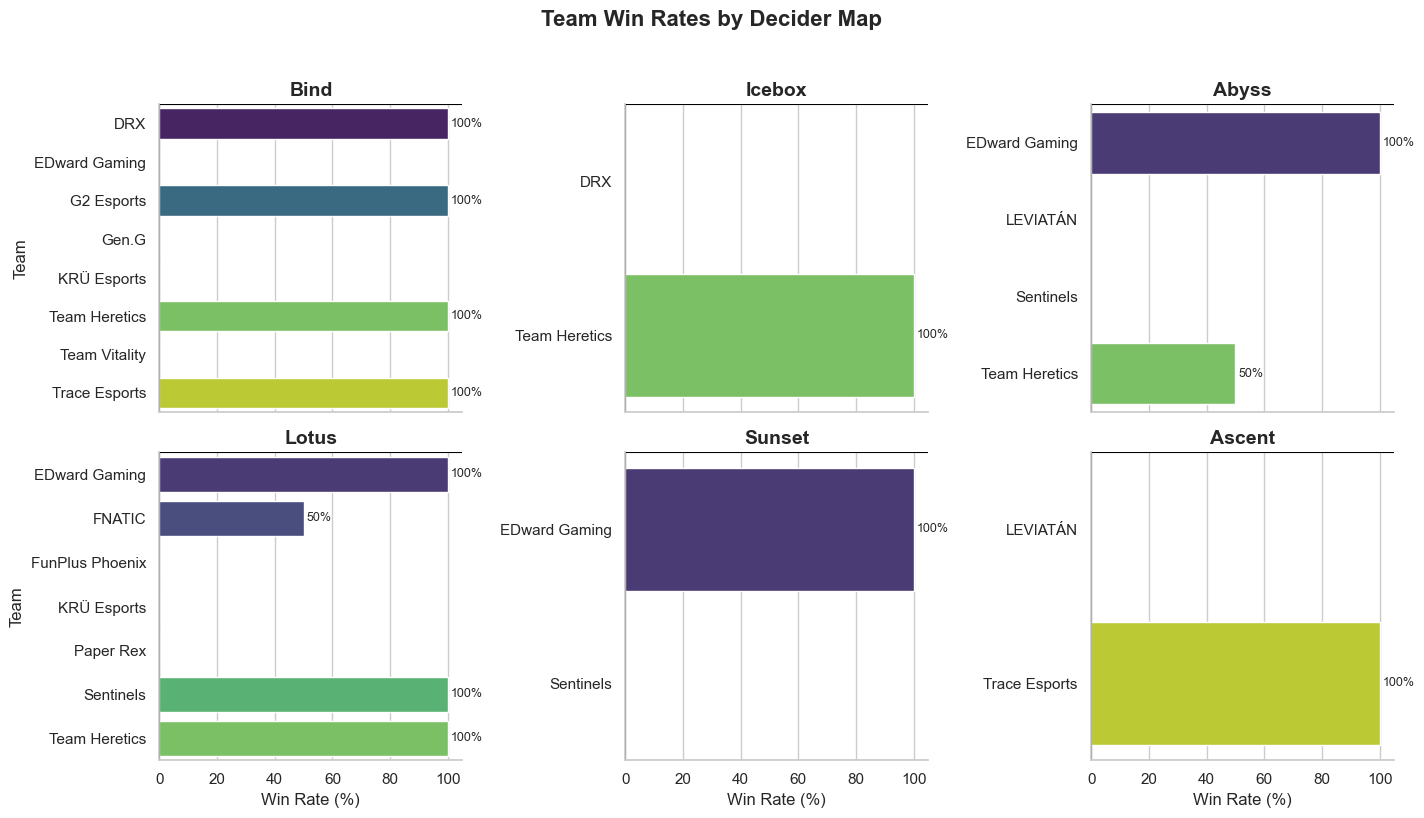

In [797]:
# winrate / pick rate on decider maps for each team

# Create the visualization

g = sns.catplot(
    data=decider_map_stats, 
    x='win_rate', 
    y='team', 
    col='map_name', 
    col_wrap=3,   # Number of graphs per row
    kind='bar', 
    height=4, 
    aspect=1.2,
    palette='viridis',
    hue = 'team',
    legend = False,
    sharey=False  # Allow different teams on y-axis for each map
)

# Customizing the layout
g.figure.suptitle('Team Win Rates by Decider Map', y=1.02, fontsize=16, fontweight = 'bold')
g.set_titles("{col_name}", weight = 'bold', size = 14)  # Title for each subplot is the Map Name
g.set_axis_labels("Win Rate (%)", "Team")

# Add text annotations for sample size (e.g., "1/1")
for ax in g.axes.flat:
    #adding lies / borders for each subplot
    ax.axvline(x = 0, color = 'black', linewidth = 0.8)
    ax.axhline(y = -0.5, color = 'black', linewidth = 0.8)
    ax.axhline(y = len(ax.patches)-0.5,color = 'black', linewidth = 0.8)
    

    # Iterate through the bars in each subplot
    for p in ax.patches:
        width = p.get_width()
        if width > 0: # Only label visible bars
            ax.text(width + 1, p.get_y() + p.get_height()/2, 
                    f'{int(width)}%', 
                    va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [798]:
matches_maps_df

,match_id,map_name,map_order,score,winner,duration,picked_by
0,378662,Haven,1,13 - 8,Gen.G,1:02:40,Sentinels
1,378662,Ascent,2,13 - 7,Gen.G,46:45,Gen.G
2,378663,Abyss,1,12 - 14,Team Heretics,1:10:12,FunPlus Phoenix
3,378663,Bind,2,13 - 9,FunPlus Phoenix,53:01,Team Heretics
4,378663,Lotus,3,13 - 15,Team Heretics,1:07:12,Decider
...,...,...,...,...,...,...,...
81,378829,Haven,1,6 - 13,Team Heretics,1:16:43,EDward Gaming
82,378829,Sunset,2,13 - 4,EDward Gaming,45:11,Team Heretics
83,378829,Lotus,3,13 - 9,EDward Gaming,55:30,EDward Gaming
84,378829,Bind,4,11 - 13,Team Heretics,1:01:45,Team Heretics


In [799]:
matches_overview_df

,match_id,format,maps_played,team1,team2,team1_score,team2_score,winner,looser,team1_ban1,team2_ban1,team1_pick1,team2_pick1,team1_ban2,team2_ban2,team1_pick2,team2_pick2,decider,series_category
0,378662,Bo3,2,Sentinels,Gen.G,2,0,Gen.G,Sentinels,Icebox,Sunset,Haven,Ascent,Bind,Lotus,Not Valid for Bo3,Not Valid for Bo3,Abyss,Bo3 (2 Maps)
1,378663,Bo3,3,FunPlus Phoenix,Team Heretics,1,2,Team Heretics,FunPlus Phoenix,Sunset,Icebox,Abyss,Bind,Ascent,Haven,Not Valid for Bo3,Not Valid for Bo3,Lotus,Bo3 (3 Maps)
2,378657,Bo3,3,KRÜ Esports,DRX,2,1,DRX,KRÜ Esports,Icebox,Lotus,Haven,Abyss,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (3 Maps)
3,378656,Bo3,2,Bilibili Gaming,FNATIC,2,0,FNATIC,Bilibili Gaming,Haven,Sunset,Bind,Lotus,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Ascent,Bo3 (2 Maps)
4,378667,Bo3,2,TALON,LEVIATÁN,2,0,LEVIATÁN,TALON,Icebox,Lotus,Bind,Ascent,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Sunset,Bo3 (2 Maps)
5,378669,Bo3,3,Trace Esports,Team Vitality,1,2,Trace Esports,Team Vitality,Icebox,Lotus,Ascent,Sunset,Abyss,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (3 Maps)
6,378674,Bo3,2,Paper Rex,G2 Esports,2,0,G2 Esports,Paper Rex,Ascent,Sunset,Icebox,Lotus,Haven,Abyss,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (2 Maps)
7,378673,Bo3,2,FUT Esports,EDward Gaming,2,0,EDward Gaming,FUT Esports,Haven,Ascent,Lotus,Bind,Abyss,Icebox,Not Valid for Bo3,Not Valid for Bo3,Sunset,Bo3 (2 Maps)
8,378664,Bo3,3,Team Heretics,Gen.G,1,2,Team Heretics,Gen.G,Ascent,Sunset,Abyss,Lotus,Icebox,Haven,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (3 Maps)
9,378658,Bo3,2,DRX,FNATIC,0,2,DRX,FNATIC,Haven,Icebox,Abyss,Lotus,Ascent,Sunset,Not Valid for Bo3,Not Valid for Bo3,Bind,Bo3 (2 Maps)


### Average Round Duration per Map
Prep the data for round duration analysis:
- Grab match_id, score, duration, and map_name and merge in team info from the overview  
- Parse score to get total rounds played  
- Convert duration to seconds (subtract 480s for timeouts + halftime)  
- Compute average round duration per map


In [800]:
# Average round duration per map for all teams
rounds_df = matches_maps_df[['match_id','score', 'duration','map_name']].copy()
rounds_df = pd.merge(rounds_df, matches_overview_df[['match_id', 'team1', 'team2']], left_on = 'match_id', right_on = 'match_id', how = 'left')

# calculate total rounds and total duration
rounds_df['total_rounds'] = rounds_df['score'].str.split(' - ').apply(lambda x : int(x[0]) + int(x[1]))
rounds_df['total_duration'] = rounds_df['duration'].str.split(':').apply(lambda x : ((int(x[0]) * 3600) + (int(x[1]) * 60) + int(x[2]) - 480 ) if len(x)==3 else ((int(x[0]) * 60) + int(x[1]) - 480)) # reduced 480 secs for 3 timeouts and  a half time

#calculate the average duration per round
rounds_df['avg_dur'] = (rounds_df['total_duration'] / rounds_df['total_rounds']).round(2)
rounds_df

,match_id,score,duration,map_name,team1,team2,total_rounds,total_duration,avg_dur
0,378662,13 - 8,1:02:40,Haven,Sentinels,Gen.G,21,3280,156.19
1,378662,13 - 7,46:45,Ascent,Sentinels,Gen.G,20,2325,116.25
2,378663,12 - 14,1:10:12,Abyss,FunPlus Phoenix,Team Heretics,26,3732,143.54
3,378663,13 - 9,53:01,Bind,FunPlus Phoenix,Team Heretics,22,2701,122.77
4,378663,13 - 15,1:07:12,Lotus,FunPlus Phoenix,Team Heretics,28,3552,126.86
...,...,...,...,...,...,...,...,...,...
81,378829,6 - 13,1:16:43,Haven,EDward Gaming,Team Heretics,19,4123,217.00
82,378829,13 - 4,45:11,Sunset,EDward Gaming,Team Heretics,17,2231,131.24
83,378829,13 - 9,55:30,Lotus,EDward Gaming,Team Heretics,22,2850,129.55
84,378829,11 - 13,1:01:45,Bind,EDward Gaming,Team Heretics,24,3225,134.38


### Stripplot of Average Map Duration
Building  a matchup label (`team1 vs team2`) and use a stripplot to show average round duration.

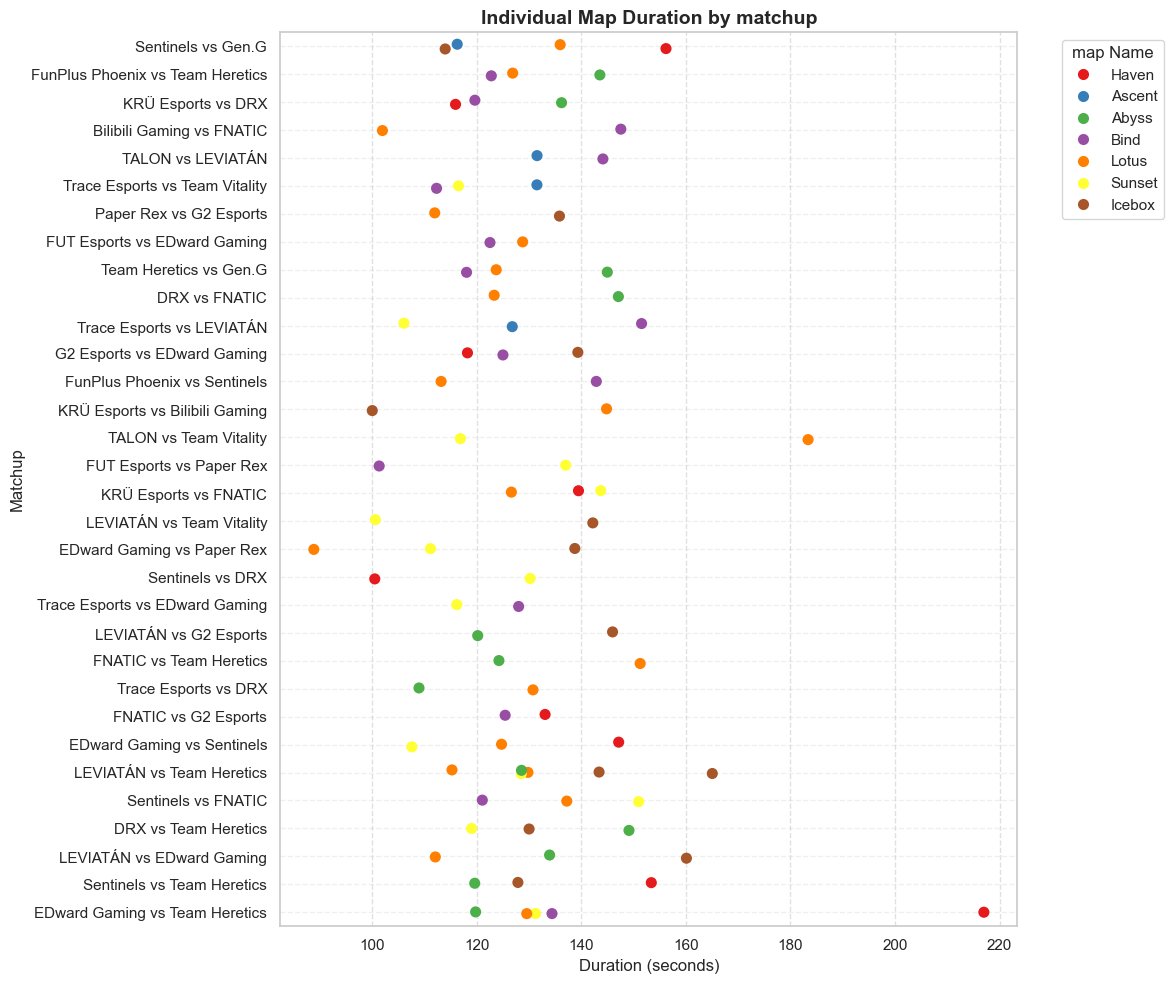

In [ ]:
# visulaize the data with strippolt for average map duration
rounds_df['matchup'] = (rounds_df['team1']) + ' vs ' + (rounds_df['team2'])

plt.figure(figsize = (12,10))
sns.stripplot(
    data = rounds_df,
    x = 'avg_dur',
    y = 'matchup',
    hue = 'map_name',
    jitter = True,
    size = 8,
    alpha = 1,
    palette = 'Set1'
)

plt.title('Individual Map Duration by matchup', weight = 'bold', size = 14)
plt.xlabel('Duration (seconds)')
plt.ylabel('Matchup')
plt.legend(title = 'map Name', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.3)
plt.tight_layout()
plt.show()

### Round Duration by Map
Check which maps tend to have longer rounds.  
Use a boxplot of average round duration per map, sorted by median values, to see the distribution clearly.


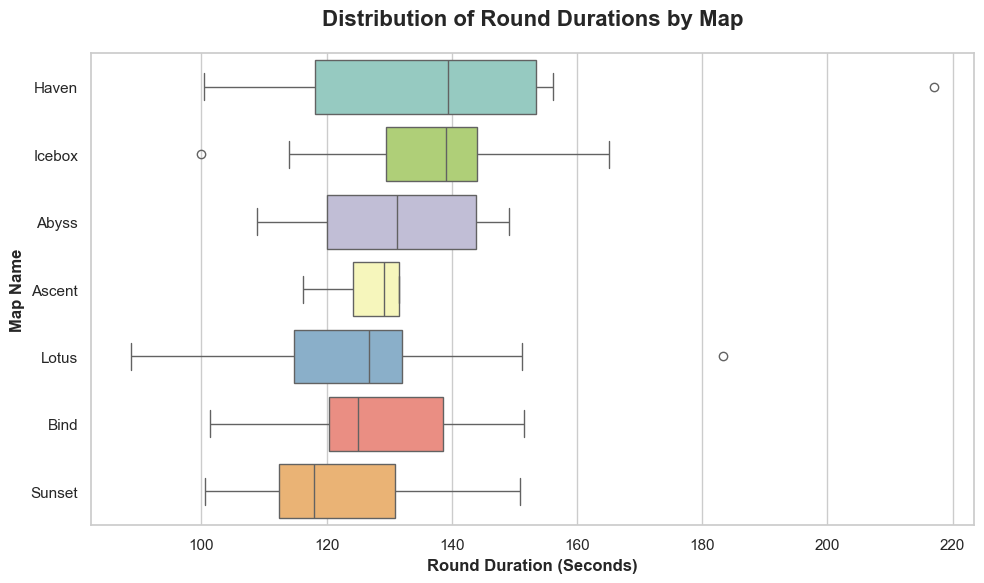

In [802]:
# which map tends to have longer rounds
sns.set_theme(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=rounds_df, 
    x='avg_dur', 
    y='map_name',
    hue ='map_name', 
    palette='Set3',
    # Sorting by median round duration
    order=rounds_df.groupby('map_name')['avg_dur'].median().sort_values(ascending=False).index)

# Add Titles and Labels
plt.title('Distribution of Round Durations by Map', weight='bold', size=16, pad=20)
plt.xlabel('Round Duration (Seconds)', weight='bold')
plt.ylabel('Map Name', weight='bold')

plt.tight_layout()
plt.show()

In [803]:
# load maps data (maps_stats.csv)
maps = pd.read_csv("VCT_2024_seoul_dataset/maps_stats.csv")
maps


,map_name,times_played,attack_win_percent,defense_win_percent
0,Lotus,20,55%,45%
1,Bind,15,54%,46%
2,Sunset,14,53%,47%
3,Abyss,12,51%,49%
4,Icebox,12,52%,48%
5,Haven,9,48%,52%
6,Ascent,4,47%,53%


### Map Distribution for the Tournament
Plot a pie chart of maps played, showing percentage share of each map across the tournament.

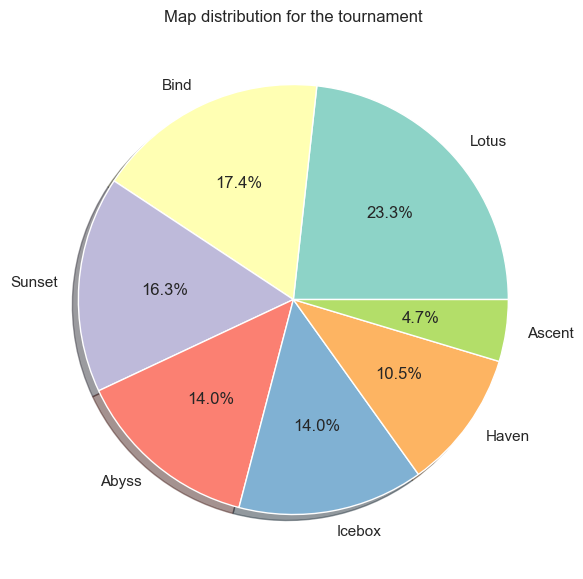

In [804]:
# Maps played distribution for the tournament
plt.figure(figsize = (6,6))
colors = plt.cm.Set3.colors

plt.pie(maps['times_played'],
        labels = maps['map_name'],
        autopct = '%1.1f%%',
        colors = colors, 
        shadow= True
)

plt.title('Map distribution for the tournament')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Attack vs Defence Win % by Map
Clean up the win % columns, convert them to floats, then plot grouped bars for attack and defence win rates.

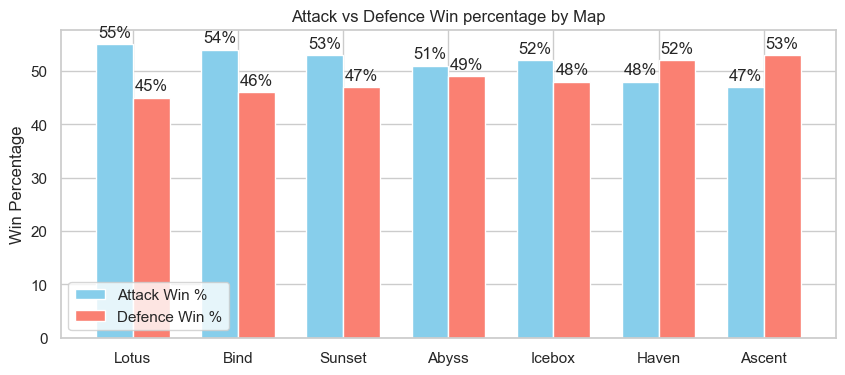

In [814]:
# Attack and Defence Win % distribution for each map
# Clean the columsn by removing the % sign and converts in float
maps['attack_win_percent'] = maps['attack_win_percent'].astype(str).str.strip('%').astype('float')
maps['defense_win_percent'] = maps['defense_win_percent'].astype(str).str.strip('%').astype('float')

# setup plot dimentions
x = np.arange(len(maps['map_name']))
width = 0.35

fig, ax = plt.subplots(figsize = (10,4)) # create figure and axes 
#  bars for Attack  & Defense Win %, shifted left/ right by half the width to prevent overlap
rects1 = ax.bar(x - width/2, maps['attack_win_percent'], width, label = 'Attack Win %', color = 'skyblue')
rects2 = ax.bar(x +width/2, maps['defense_win_percent'], width, label = 'Defence Win %', color = 'salmon')

# Add labels
ax.set_ylabel('Win Percentage')
ax.set_title('Attack vs Defence Win percentage by Map')
ax.set_xticks(x)
ax.set_xticklabels(maps['map_name'])
ax.legend()

# Define fucntion to add value labels at the top of the bars

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}%', xy = (rect.get_x() + rect.get_width()/2, height),
        xytext = (0,3), textcoords = 'offset points', ha = 'center',va = 'bottom')
# xy = (rect.get_x() + rect.get_width()/2, height) -> It places the label at the center-top of each bar 
# by using the bar’s midpoint on the x-axis and its height on the y-axis
# xytext=(0,3) → shifts the label 3 points above the bar
# ha='center' → horizontally centered
# va='bottom' → vertically aligned at the bottom of the text

autolabel(rects1)
autolabel(rects2)


plt.show()
